<h1 style = "text-align: center">Collaborative Filtering Data Model</h1>

<h3 style = "text-align: center">Food.com Recipe Recommender - SOEN 471 (Big Data Analytics)</h3>

## Objective:
The objective of this notebook is to create a recommender system data model that recommend recipes based on user preferences using collaborative filtering.

In [1]:
import os
import json
import seaborn
import numpy as np
import pandas as pd 
import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# accessing directory
for dirname, _, filenames in os.walk('./clean_data'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Reading files:

In [2]:
# Removing column titled "Unnamed: 0"
training = dd.read_csv("./clean_data/interactions_TRAIN.csv").drop("Unnamed: 0", axis=1)
testing = dd.read_csv("./clean_data/interactions_TEST.csv").drop("Unnamed: 0", axis=1)
recipes = dd.read_csv("./clean_data/recipes.csv").drop("Unnamed: 0", axis=1)

## Print Training Data

In [3]:
training.head()

,user_id,recipe_id,date,rating,review
0,59801,8060,2007-12-11,5,This really is a great basic meatball recipe. ...
1,104295,38353,2005-02-08,5,Very yummy. I quartered the recipe and theref...
2,58104,162999,2007-03-05,5,OK this may be a great Canadian drink! But whe...
3,2000207498,2886,2015-05-16,5,Great recipe. I made a lot of changes though a...
4,41695,27082,2002-06-10,4,"Very easy to make and I liked it, my kids didn..."


In [4]:
recipes[recipes['recipe_id'] == 0].compute()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,Calories,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV


## Print Recipes Data

In [5]:
recipes.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,Calories,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


## Add user rating column per recipe

In [6]:
recipes_ratings = dd.merge(recipes, training)
recipes_ratings.head(5)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV,user_id,date,rating,review
0,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2000264903,2015-06-12,0,Why would you say you believe Arby&#039;s used...
1,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2001687401,2017-08-26,5,I was a manager of Arby's and I have made tons...
2,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,766961,2010-09-14,5,"Thank you for posting this! I love this, it's..."
3,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2000289585,2015-06-23,0,You should actually use 1 lb of chicken not 8 ...
4,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,657495,2007-11-19,5,My boyfriend said this tasted better than the ...


## Making User-Item Matrix

In [7]:
training = training.head(90000)
ratings_matrix = training.pivot_table(index='recipe_id',columns='user_id',values='rating')
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(15)

user_id,1533,1535,1634,1773,1792,1891,2046,2059,2178,2310,...,2002361851,2002362510,2002362634,2002365467,2002366577,2002366607,2002368308,2002368940,2002371792,2002372706
recipe_id,,,,,,,,,,,,,,,,,,,,,
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Performing Cosine Similarity

In [8]:
recipe_similarity = cosine_similarity(ratings_matrix)
np.fill_diagonal(recipe_similarity, 0) 
recipe_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Distribution of n_ingredients and n_steps

C:\Users\Smoky\AppData\Local\Temp\ipykernel_33696\3305907051.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(recipes["n_ingredients"],ax=ax[0])
C:\Users\Smoky\AppData\Local\Temp\ipykernel_33696\3305907051.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(recipes["n_steps"],ax=ax[1]

<Axes: xlabel='n_steps', ylabel='Density'>

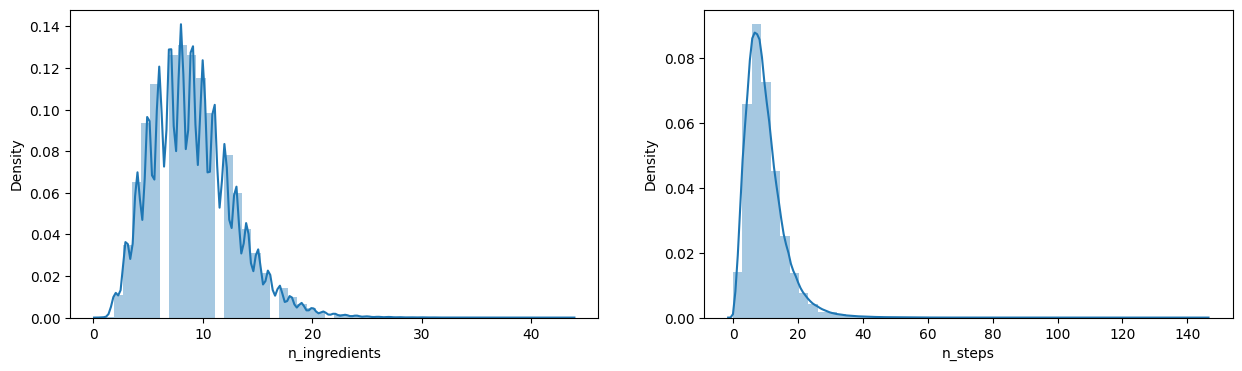

In [9]:
fig,ax = plt.subplots(1, 2, figsize=(15, 4))
seaborn.distplot(recipes["n_ingredients"],ax=ax[0])
seaborn.distplot(recipes["n_steps"],ax=ax[1])

## Relationship between different variables in a dataset:

<Axes: xlabel='n_ingredients', ylabel='n_steps'>

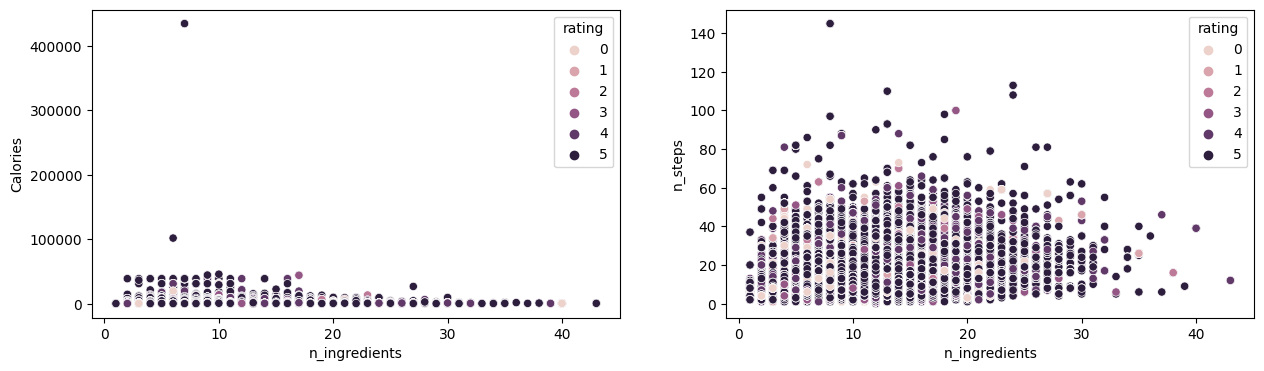

In [10]:
fig,ax = plt.subplots(1, 2, figsize=(15,4))
seaborn.scatterplot(data=recipes_ratings, x="n_ingredients", y="Calories", hue="rating", ax=ax[0])
seaborn.scatterplot(data=recipes_ratings, x="n_ingredients", y="n_steps", hue="rating", ax=ax[1]) 

## Item-Item Recommendation Class:

In [11]:
class ItemItem_Recommendations:
    
    def __init__(self, recipes):
        self.recipes = recipes
    
    def recommend_five_recipes(self, recipe_id):
        allRecipes = self.recipes

        # Select the columns containing the nutritional information
        nutritional_columns = ['Calories', 'Total_fat_PDV', 'Sugar_PDV', 'Sodium_PDV', 'Protein_PDV', 'Saturated_fat_PDV', 'Carbohydrates_PDV']

        # Fill missing values with zeros
        allRecipes[nutritional_columns] = allRecipes[nutritional_columns].fillna(0)

        # If the recipe_id is NOT present in allRecipes
        if recipe_id not in list(allRecipes['recipe_id'].values):
            print("recipe_id not found")
            return []
        # If the recipe_id is present in allRecipes
        else:
            # Print the information of the passed recipe_id
            recipe_info = allRecipes[allRecipes['recipe_id'] == recipe_id][['name', 'Calories', 'Total_fat_PDV', 'Sugar_PDV', 'Sodium_PDV', 'Protein_PDV', 'Saturated_fat_PDV', 'Carbohydrates_PDV']].to_dict('records')[0]
            print(json.dumps(recipe_info, indent=4))

            # Compute the cosine similarities between the recipes
            recipe_nutrition = da.from_array(np.vstack(allRecipes[nutritional_columns].values))
            similarity_scores = cosine_similarity(recipe_nutrition, recipe_nutrition[allRecipes.index[allRecipes['recipe_id'] == recipe_id]])

            # Get the top 5 most similar recipes
            top_recipe_indices = np.argsort(similarity_scores.ravel())[::-1][1:6]
            top_recipe_ids = allRecipes.iloc[top_recipe_indices]['recipe_id'].values.tolist()

            # Create a dictionary for each recipe containing its name and nutritional information
            recommended_recipes = []
            for recipe_id in top_recipe_ids:
                recipe_info = {}
                recipe_info['name'] = allRecipes[allRecipes['recipe_id'] == recipe_id]['name'].values[0]
                recipe_info['nutritional_info'] = allRecipes[allRecipes['recipe_id'] == recipe_id][nutritional_columns].to_dict('records')[0]
                recommended_recipes.append(recipe_info)

            # Return the recommended recipes
            print("_____ The Recommmended Top 5 Most Similar Recipes _____")
            return recommended_recipes

## Testing the model given a rando recipe_id:

In [12]:
model = ItemItem_Recommendations(recipes.head(10000))
model.recommend_five_recipes(137739)

{
    "name": "arriba   baked winter squash mexican style",
    "Calories": 51.5,
    "Total_fat_PDV": 0.0,
    "Sugar_PDV": 13.0,
    "Sodium_PDV": 0.0,
    "Protein_PDV": 2.0,
    "Saturated_fat_PDV": 0.0,
    "Carbohydrates_PDV": 4.0
}
_____ The Recommmended Top 5 Most Similar Recipes _____


[{'name': 'an mochi  1',
  'nutritional_info': {'Calories': 1543.6,
   'Total_fat_PDV': 6.0,
   'Sugar_PDV': 401.0,
   'Sodium_PDV': 0.0,
   'Protein_PDV': 37.0,
   'Saturated_fat_PDV': 6.0,
   'Carbohydrates_PDV': 117.0}},
 {'name': 'afrikaanse stoofschotel',
  'nutritional_info': {'Calories': 208.4,
   'Total_fat_PDV': 1.0,
   'Sugar_PDV': 52.0,
   'Sodium_PDV': 1.0,
   'Protein_PDV': 14.0,
   'Saturated_fat_PDV': 0.0,
   'Carbohydrates_PDV': 15.0}},
 {'name': '2 ingredient cookies',
  'nutritional_info': {'Calories': 86.2,
   'Total_fat_PDV': 1.0,
   'Sugar_PDV': 19.0,
   'Sodium_PDV': 0.0,
   'Protein_PDV': 4.0,
   'Saturated_fat_PDV': 0.0,
   'Carbohydrates_PDV': 6.0}},
 {'name': 'apricot oat cakes',
  'nutritional_info': {'Calories': 224.0,
   'Total_fat_PDV': 2.0,
   'Sugar_PDV': 50.0,
   'Sodium_PDV': 0.0,
   'Protein_PDV': 12.0,
   'Saturated_fat_PDV': 1.0,
   'Carbohydrates_PDV': 15.0}},
 {'name': 'apricot honey oatmeal',
  'nutritional_info': {'Calories': 407.1,
   'Total_fa